In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma, uniform, randint, skewnorm
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker
from unidecode import unidecode_expect_ascii
from itertools import repeat

In [2]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,30)
staff_number = 6
tournament_number = 20
customers_number = 1500

# Faza 1 - przygotowanie

## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [4]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))
prompt_tournaments = pd.read_csv(file_path('turnieje.csv'), delimiter=';')

## Tabela prompt_dates

In [5]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [6]:
generated_dates = gen_dates(shop_open_date, today)

In [7]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')
prompt_dates['Data']

0     2021-06-01
1     2021-06-02
2     2021-06-04
3     2021-06-05
4     2021-06-07
         ...    
629   2023-06-26
630   2023-06-27
631   2023-06-28
632   2023-06-29
633   2023-06-30
Name: Data, Length: 634, dtype: datetime64[ns]

## Ruch - dni

In [8]:
A = 12
B = 0.02 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(round(A+B*i+dd))

In [9]:
prompt_dates['volume_base'] = volume_base

In [10]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [11]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,round(0.4*v_base+szum)))

prompt_dates['volume_rental'] = volume_rental

In [12]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,13,14,3
1,2021-06-02,Środa,12,13,7
2,2021-06-04,Piątek,17,15,9
3,2021-06-05,Sobota,17,19,7
4,2021-06-07,Poniedziałek,14,12,7


## Tabela procentowa z godzinami

In [13]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [14]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

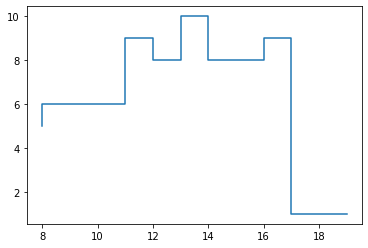

In [15]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [16]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [17]:
sum(hours_prompt['Natężenie'])

1.0

## Gry

In [18]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [19]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,Catan: Osadnicy z Catanu,planszowa,strategiczna,"Catan to gra, w której można poczuć się jak os...",TAK,129.99,14.0,4.0
2,Mistrz Słowa,inna,logiczna,Mistrz słowa - to pasjonująca gra słowna dla 2...,TAK,40.25,NaN,10.0
3,Concordia,planszowa,strategiczna,Dwa tysiące lat temu Imperium Rzymskie zajmowa...,NIE,177.00,25.0,NaN
4,Podaj Łapę,karciana,familijna,Gracze zostają wolontariuszami schroniska i po...,NIE,136.44,9.0,NaN


In [20]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [21]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,wagi
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,Catan: Osadnicy z Catanu,planszowa,strategiczna,"Catan to gra, w której można poczuć się jak os...",TAK,129.99,14.0,4.0,0.044128
2,Mistrz Słowa,inna,logiczna,Mistrz słowa - to pasjonująca gra słowna dla 2...,TAK,40.25,NaN,10.0,0.042363
3,Concordia,planszowa,strategiczna,Dwa tysiące lat temu Imperium Rzymskie zajmowa...,NIE,177.00,25.0,NaN,0.040669
4,Podaj Łapę,karciana,familijna,Gracze zostają wolontariuszami schroniska i po...,NIE,136.44,9.0,NaN,0.039043


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [22]:
id_generator = lambda n: [*range(1, n+1)]


gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.').apply(lambda x: unidecode_expect_ascii(x))
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False).apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [23]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['city'] = np.full((1, staff.shape[0]), 'Wrocław')[0]
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff.sort_values(by=['updated_at'], inplace=True)
    staff['staff_id'] = id_generator(n)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [24]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
2,1,KRYSTIAN,DĄBROWSKI,735328271,KRYSTIAN.DABROWSKI@mail.pl,Wrocław,3723.76,False,M,2021-06-01,NaN,2021-06-01 09:26:46
3,2,RYSZARD,PANKIEWICZ,506634128,RYSZARD.PANKIEWICZ@poczta.pl,Wrocław,4058.09,True,M,2021-06-01,NaN,2021-06-01 09:51:12
1,3,VIKTOR,OLECH,454077431,VIKTOR.OLECH@polska.pl,Wrocław,3608.67,False,M,2021-06-01,NaN,2021-06-01 11:23:52
0,4,MAŁGORZATA,MARCINKOWSKA,603862846,MALGORZATA.MARCINKOWSKA@chello.pl,Wrocław,3621.05,False,F,2021-06-01,NaN,2021-06-01 16:19:02
4,5,DANUTA,KWIATKOWSKA,885929230,DANUTA.KWIATKOWSKA@yahoo.com,Wrocław,NaN,False,F,2021-06-01,2022-11-14,2022-11-14 13:37:26
5,6,STANISŁAW,ADAMCZYK,518648356,STANISLAW.ADAMCZYK@onet.pl,Wrocław,3704.10,False,M,2022-12-14,NaN,2022-12-14 11:52:57


## Godziny pracy

In [25]:
def weekday_hour_worker_generator():    
    hours = range(8,20)
    weekdays = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota']

    w = []
    h = []
    for i in hours:
        for j in weekdays:
            w.append(j)
            h.append(i)
    wk = []
    for i in h:
        if i < 14:
            wk.append((1,2))
        else:
            wk.append((3,4,6))
            
    weekday_hour_worker = pd.DataFrame({
        'weekdays': w, 
        'hour': h, 
        'staff': wk
    })
    return weekday_hour_worker

In [26]:
weekday_hour_worker = weekday_hour_worker_generator()
weekday_hour_worker.head()

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"


## Związki

In [27]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [28]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today) + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = id_generator(df.shape[0])
    df['partner_id'] = id_generator(df.shape[0])
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [29]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
7,1,2,M,1,3,2021-07-04 15:15:34
5,2,1,M,2,5,2022-03-27 15:16:01
8,3,4,F,3,4,2022-04-02 18:22:32
1,4,4,F,4,6,2022-06-02 14:41:30
2,5,3,M,5,7,2022-07-08 18:50:39
0,6,4,F,6,6,2022-08-06 14:51:59
6,7,6,M,7,9,2023-02-18 18:18:02
4,8,6,M,8,6,2023-04-15 15:39:18
3,9,3,M,9,7,2023-04-21 13:39:01


## Partnerzy

In [30]:
def partners_df_generator(relationships_df):
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [31]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
7,1,AGNIESZKA,F,2021-07-04 15:15:34
5,2,MARTA,F,2022-03-27 15:16:01
8,3,WOJCIECH,M,2022-04-02 18:22:32
1,4,GINTER,M,2022-06-02 14:41:30
2,5,ROMA,F,2022-07-08 18:50:39
0,6,BOŻENA,F,2022-08-06 14:51:59
6,7,TETIANA,F,2023-02-18 18:18:02
4,8,MARTA,F,2023-04-15 15:39:18
3,9,GRAŻYNA,F,2023-04-21 13:39:01


## Klienci - część A

In [32]:
customers = pd.DataFrame({'customer_id': id_generator(customers_number)})

## Koszty utrzymania

In [33]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(prompt_dates.loc[(prompt_dates['Data'].dt.day == day) | (prompt_dates['Data'].dt.day == day+1), 'Data'])
    base['flag'] = base['Data'].dt.to_period('M') 
    base.drop_duplicates(['flag'], keep='first', inplace=True)
    base = base.reset_index()
    return base['Data']

In [34]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'CZYNSZ ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'CZYNSZ')[0]
    })
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'ENERGIA ELEKTRYCZNA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df

def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'WODA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'OGRZEWANIE ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat([staff_df[['first_name', 'last_name', 'current_salary']]]*date_df.shape[0], ignore_index=True)
    staff_name = staff_df['first_name'].str.cat(staff_df['last_name'], sep=' ')
    names = pd.concat([staff_name]*date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()['Data']
    title_first = dates.dt.month_name(locale='pl_PL').apply(lambda x: 'PENSJA ' + str(x).upper())
    title = title_first.str.cat(names, sep=' ')
    df = pd.DataFrame({
        'date': dates,
        'title': title,
        'amount': all_staff['current_salary'],
        'type': np.full((1, title.shape[0]), 'PENSJA')[0]
    })
    to_date = pd.to_datetime(staff_df['to_date'].loc[staff_df['to_date'].isnull() == False].values[0])
    df.loc[(df['amount'].isnull() == True) & (df['date'] < to_date), 'amount'] = round(3490 + expon.rvs(scale=100, loc=80), 2)
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame({
        'date': [],
        'title': [],
        'amount': [],
        'type': [],
        'updated_at': []
    })
    df = pd.concat([df, rent_generator(), energy_generator(), water_generator(), heat_generator(), salary_generator(staff)])
    df['updated_at'] = df['date'].apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df.sort_values(by=['updated_at'], inplace=True)
    df['payment_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df['spend_id'] = id_generator(df.shape[0])
    df = df.reindex(['spend_id', 'title', 'amount', 'type','date', 'payment_id', 'invoice_id', 'updated_at'], axis=1)
    return df

In [35]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,ENERGIA ELEKTRYCZNA CZERWIEC,148.26,MEDIA,2021-06-05,1,1,2021-06-05 16:20:21
3,2,WODA CZERWIEC,50.21,MEDIA,2021-06-05,2,2,2021-06-05 19:06:29
3,3,CZYNSZ CZERWIEC,3250.00,CZYNSZ,2021-06-05,3,3,2021-06-05 19:40:38
5,4,PENSJA CZERWIEC STANISŁAW ADAMCZYK,3704.10,PENSJA,2021-06-10,4,4,2021-06-10 09:14:47
1,5,PENSJA CZERWIEC RYSZARD PANKIEWICZ,4058.09,PENSJA,2021-06-10,5,5,2021-06-10 12:19:07
...,...,...,...,...,...,...,...,...
145,206,PENSJA CZERWIEC RYSZARD PANKIEWICZ,4058.09,PENSJA,2023-06-10,206,206,2023-06-10 09:21:19
147,207,PENSJA CZERWIEC MAŁGORZATA MARCINKOWSKA,3621.05,PENSJA,2023-06-10,207,207,2023-06-10 10:30:51
144,208,PENSJA CZERWIEC KRYSTIAN DĄBROWSKI,3723.76,PENSJA,2023-06-10,208,208,2023-06-10 11:03:53
146,209,PENSJA CZERWIEC VIKTOR OLECH,3608.67,PENSJA,2023-06-10,209,209,2023-06-10 14:46:51


## Typy wydatków

In [36]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame({
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['expenses_type'], keep='last', inplace=True)
    df.sort_values(by=['updated_at'], inplace=True)
    df['expenses_type_id'] = id_generator(df.shape[0])
    df = df.reindex(['expenses_type_id', 'expenses_type', 'updated_at'], axis=1)
    return df

In [37]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,MEDIA,2023-06-05 13:13:43
612,2,CZYNSZ,2023-06-05 19:57:57
149,3,PENSJA,2023-06-10 19:30:42


## Tytuły wydatków

In [38]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame({
        'title': expense_df['title'],
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['title'], keep='last', inplace=True)
    df = pd.merge(df, expense_types_df[['expenses_type_id', 'expenses_type']], how='left', on=['expenses_type'])
    df.sort_values(by=['updated_at'], inplace=True)
    df['title_id'] = id_generator(df.shape[0])
    df = df.reindex(['title_id', 'title', 'expenses_type_id', 'updated_at'], axis=1)
    return df

In [39]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA GRUDZIEŃ DANUTA KWIATKOWSKA,3,2021-12-10 12:42:42
1,2,PENSJA STYCZEŃ DANUTA KWIATKOWSKA,3,2022-01-10 18:30:35
2,3,CZYNSZ LUTY,2,2022-02-05 11:02:57
3,4,OGRZEWANIE LUTY,1,2022-02-05 11:14:30
4,5,WODA LUTY,1,2022-02-05 12:58:32


## Wydatki i tytuły jeszcze raz

In [40]:
maintenance_expenses2 = pd.merge(maintenance_expenses, expense_titles[['title_id', 'title']], how='left', on='title')
maintenance_expenses2.sort_values(by=['updated_at'], inplace=True)
maintenance_expenses2 = maintenance_expenses2.reindex(['spend_id', 'title_id', 'type', 'amount','payment_id', 'invoice_id', 'updated_at'], axis=1)

In [41]:
maintenance_expenses2.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,107,MEDIA,148.26,1,1,2021-06-05 16:20:21
1,2,106,MEDIA,50.21,2,2,2021-06-05 19:06:29
2,3,108,CZYNSZ,3250.00,3,3,2021-06-05 19:40:38
3,4,113,PENSJA,3704.10,4,4,2021-06-10 09:14:47
4,5,109,PENSJA,4058.09,5,5,2021-06-10 12:19:07


## Turnieje

In [42]:
def game_tournament_generator():
    games = prompt_games.loc[prompt_games['Turniej'] == 'TAK', ['Nazwa', 'rodzaj', 'kategoria']]
    tournament_games = pd.merge(games, prompt_tournaments, left_on=['rodzaj', 'kategoria'], right_on=['Rodzaj', 'Kategoria'], suffixes=['_gry', '_turnieju'])
    tournament_games = tournament_games[['Nazwa_gry', 'Nazwa_turnieju']]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == 'Piątek') & (weekday_hour_worker['hour'] >= 15)]['staff'].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2**x
        x -= 1
    return suma


In [43]:
def tournaments_df_generator():
    dates = pd.DataFrame(prompt_dates.loc[prompt_dates['Dzień tygodnia'] == 'Piątek', 'Data'].iloc[::6]).reset_index()['Data']
    n = dates.shape[0]
    tournament = game_tournament_generator()
    tournament = tournament.sample(n, replace=False, ignore_index=True) #nie może być ten sam wiersz
    tree_levels_number = randint.rvs(2, 4, size=n)
    matches = map(lambda x: count_matches(x), tree_levels_number)
    df = pd.DataFrame({
        'name': tournament['Nazwa_turnieju'],
        'game': tournament['Nazwa_gry'],
        'start_time': dates + datetime.timedelta(hours=15),
        'matches': matches,
        'tree_levels': tree_levels_number,
        'fee': np.full((1, n), 50)[0],
        'sign_up_deadline': dates - datetime.timedelta(days=3) + datetime.timedelta(hours=20),
        'staff_id': [tournament_staff_generator() for i in range(n)],
        'expenses': map(lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=n)),
        'updated_at': dates.apply(lambda x: x + datetime.timedelta(hours=15, minutes=random.randint(1,5), seconds=random.randint(1,59)))
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['tournament_id'] = id_generator(n)
    df['invoice_id'] = id_generator(n)
    df = df.reindex(['tournament_id', 'name', 'game', 'start_time', 'matches', 'tree_levels', 'fee', 'sign_up_deadline', 'staff_id', 'expenses', 'invoice_id', 'updated_at'], axis=1)
    return df

In [44]:
tournaments = tournaments_df_generator()
tournaments.head()

,tournament_id,name,game,start_time,matches,tree_levels,fee,sign_up_deadline,staff_id,expenses,invoice_id,updated_at
0,1,Wrocławski Konwent Planszówkowy,7 Cudów Świata,2021-06-04 15:00:00,15,3,50,2021-06-01 20:00:00,3,272.53,1,2021-06-04 15:05:29
1,2,Krucjata Karcianych Mistrzów,Dixit Odyseja,2021-07-16 15:00:00,15,3,50,2021-07-13 20:00:00,3,288.68,2,2021-07-16 15:01:09
2,3,Wrocławski Festiwal Gier Planszowych,Wsiąść do Pociągu: Europa,2021-08-27 15:00:00,15,3,50,2021-08-24 20:00:00,6,213.50,3,2021-08-27 15:04:57
3,4,Wrocławski Konwent Planszówkowy,Terraformacja Marsa,2021-10-08 15:00:00,15,3,50,2021-10-05 20:00:00,3,208.60,4,2021-10-08 15:01:15
4,5,Krucjata Karcianych Mistrzów,Munchkin,2021-11-19 15:00:00,15,3,50,2021-11-16 20:00:00,3,228.20,5,2021-11-19 15:04:23


## Udziały

In [45]:
def sign_up_date_generator(deadline):
    deadline = pd.to_datetime(deadline)
    date = pd.to_datetime(prompt_dates['Data'].loc[(prompt_dates['Data'] < deadline) & (prompt_dates['Data'] > deadline - pd.DateOffset(days=14))].sample(1, ignore_index=True).values[0])
    date += pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60)))
    return date

In [46]:
def participations_df_generator(tournament_df, customers_df):
    #liczba uczestników
    players = pd.merge(tournament_df[['game', 'tree_levels', 'tournament_id', 'fee', 'sign_up_deadline']], prompt_games[['Nazwa', 'Liczba uczestników']], left_on=['game'], right_on=['Nazwa'], how='left')
    players['Liczba uczestników'] = players['Liczba uczestników'].astype('int')
    players_number = players['Liczba uczestników'] * (2**players['tree_levels'])
    players['players'] = players_number

    #customer_id i miejsce
    participants = map(lambda x: customers_df['customer_id'].sample(x, replace=False, ignore_index=True).values, players_number)
    players['place'] = players['players'].apply(lambda x: [*range(1, x+1)])
    players['customer_id'] = list(participants)

    #ostateczny df
    df = players[['tournament_id', 'customer_id', 'fee', 'sign_up_deadline', 'place']]
    df = df.explode(['customer_id', 'place'], ignore_index=True)
    df['sign_up_date'] = df['sign_up_deadline'].apply(lambda x: sign_up_date_generator(x))
    df['updated_at'] = df['sign_up_date'].copy()
    df.sort_values(by=['updated_at'], inplace=True)
    df['particip_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df = df.reindex(['particip_id', 'tournament_id', 'customer_id', 'place', 'sign_up_date', 'fee', 'invoice_id', 'updated_at'], axis=1)
    return df

In [47]:
participations = participations_df_generator(tournaments, customers)
participations.head()

,particip_id,tournament_id,customer_id,place,sign_up_date,fee,invoice_id,updated_at
26,1,1,439,27,2021-06-01 08:13:14,50,1,2021-06-01 08:13:14
45,2,1,123,46,2021-06-01 08:25:45,50,2,2021-06-01 08:25:45
24,3,1,1156,25,2021-06-01 08:35:27,50,3,2021-06-01 08:35:27
6,4,1,1402,7,2021-06-01 09:02:36,50,4,2021-06-01 09:02:36
38,5,1,352,39,2021-06-01 09:27:02,50,5,2021-06-01 09:27:02


## Magazyn

In [48]:
def get_value_from_another_column(df, search_column, search_value, target_column):
    matching_rows = df.loc[df[search_column] == search_value]
    target_value = matching_rows[target_column].values[0]
    return target_value


def sell(): 
    N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    while N < 2500 or N > 3700: 
        N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    ilość = list(map(round,prompt_games['wagi']*N))
    M = [prompt_games['Nazwa'][i:i+5] for i in range(0, len(prompt_games['Nazwa']), 5)]
    daty = []
    datysklepowe = list(prompt_dates['Data'].dt.strftime('%Y-%m-%d'))
    ilość2 = [sum(ilość[i:i+5]) for i in range(0,51,5)]
    for i in range(len(M)):
        d = max(len(M) + round(norm.rvs(0,5)),1)
        day = datetime.datetime(random.choice(range(2021,2024)),random.choice(range(1,13)),d).strftime("%Y-%m-%d")
        while day not in datysklepowe:
            day = datetime.datetime(random.choice(range(2021, 2024)), random.choice(range(1, 13)), d).strftime("%Y-%m-%d")
        daty.append(day)
    index = [x for x, y in zip(range(1,len(M)+1), ilość2) for _ in range(y)]
    indexy = [x for x, y in zip(index, ilość2) for _ in range(y)]
    daty_dost = [x for x, y in zip(daty, ilość2) for _ in range(y)]
    game = [x for x, y in zip(prompt_games['Nazwa'], ilość) for _ in range(y)]
    upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty_dost]
    ceny = [x for x, y in zip(prompt_games['Kupno'], ilość2) for _ in range(y)]
    df = pd.DataFrame({
        'game': game,
        'destination': ['S' for _ in range(len(indexy))],
        'price': ceny,
        'active': [True for i in range(len(upd))],
        'purchase_payment': [round(0.8*cena, 2) for cena in ceny],
        'delivery_date': upd,
        'updated_at': upd
    }) 
    return df


def rental():
    N = 70
    games_r = [random.choice(prompt_games['Nazwa']) for i in range(N)]
    daty = ['2021-06-01' for _ in range(N)]
    daty_upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty]
    df = pd.DataFrame({
        'game': games_r,
        'destination': ['R' for _ in range(N)],
        'price': [round(0.1*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'active': [True for i in range(N)],
        'purchase_payment': [round(0.8*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'delivery_date': daty_upd,
        'updated_at': daty_upd
    }) 
    return df


def games_for_tournament(tournaments_df):
    games_amount = tournaments_df[['game', 'tree_levels']].groupby('game').max().apply(lambda x: 2**x)
    games = pd.merge(games_amount, prompt_games, left_on=['game'], right_on=['Nazwa'])[['tree_levels', 'Nazwa', 'Kupno']]
    n = games.shape[0]
    dates = ['2021-06-01' for _ in range(n)]
    updated = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in dates]
    df = pd.DataFrame({
        'game': games['Nazwa'],
        'destination': ['T' for _ in range(n)],
        'price': [np.nan for i in range(n)],
        'active': [True for i in range(n)],
        'purchase_payment': games['Kupno'],
        'delivery_date': updated,
        'updated_at': updated
    })
    return df


def inventory_df_generator(tournaments_df):
    sell_df = sell()
    rental_df = rental()
    tournament_df = games_for_tournament(tournaments_df)
    df = pd.concat([sell_df, rental_df, tournament_df])
    df.sort_values(by=['updated_at'], inplace=True)
    df['inventory_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df = df.reindex(['inventory_id', 'game', 'destination', 'price', 'active', 'purchase_payment', 'invoice_id', 'delivery_date', 'updated_at'], axis=1)
    return df

In [49]:
inventory = inventory_df_generator(tournaments)
inventory.head()

,inventory_id,game,destination,price,active,purchase_payment,invoice_id,delivery_date,updated_at
60,1,Cyklady: Monumenty,R,3.82,True,30.56,1,2021-06-01 08:15:45,2021-06-01 08:15:45
5,2,Munchkin,T,NaN,True,44.90,2,2021-06-01 08:36:56,2021-06-01 08:36:56
11,3,Wsiąść do Pociągu: Europa,T,NaN,True,141.90,3,2021-06-01 08:38:10,2021-06-01 08:38:10
50,4,UNO,R,2.28,True,18.26,4,2021-06-01 08:47:10,2021-06-01 08:47:10
67,5,Ubongo,R,8.15,True,65.17,5,2021-06-01 08:48:42,2021-06-01 08:48:42


## Ceny gier

In [50]:
def game_prices_df_generator(inventory_df):
    df = inventory_df.drop_duplicates(subset=['price'], keep='last', ignore_index=True)[['price', 'updated_at']]
    df.rename(columns={'price': 'current_price'}, inplace=True)
    df = df.sort_values(['updated_at'])
    df['price_id'] = id_generator(df.shape[0])
    df = df.reindex(['price_id', 'current_price', 'updated_at'], axis=1)
    return df

In [51]:
game_prices = game_prices_df_generator(inventory)
game_prices.head()

,price_id,current_price,updated_at
0,1,3.82,2021-06-01 08:15:45
1,2,4.49,2021-06-01 09:26:54
2,3,13.00,2021-06-01 09:28:30
3,4,3.30,2021-06-01 10:48:55
4,5,8.25,2021-06-01 10:50:59


## Sprzedaże

In [52]:
def sales_df_generator(inventory_df):
    all_date = []
    price = []
    invoice = []
    staff = []
    inventory = []
    for j in range(prompt_dates['Data'].shape[0]):
        for i in range(prompt_dates['volume_sales'][j]):
            hour = random.choices(hours_prompt['Godzina'], weights=hours_prompt['Natężenie'], k=1)[0]
            date = prompt_dates['Data'][j] + datetime.timedelta(hours=int(hour), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            P = random.choices([1, 2, 3], weights=[0.7, 0.25, 0.05])[0]
            games = random.choices(prompt_games['Nazwa'], weights=prompt_games['wagi'], k=P)
            available_staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == date.day_name(locale='pl_PL')) & (weekday_hour_worker['hour'] == date.hour)]['staff'].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            for k in games:
                mask = (inventory_df['game'] == k) & (inventory_df['delivery_date'] < date) & (inventory_df['destination'] == 'S') & (inventory_df['active'] == True)
                if mask.any():
                    inventory_df.loc[mask.idxmax(), 'active'] = False
                    price.append(inventory_df['price'].loc[mask.idxmax()])
                    all_date.append(date)
                    invoice.append(f'{i}_{j}')
                    staff.append(staff_id)
                    inventory.append(inventory_df['inventory_id'].loc[mask.idxmax()])
                    
    df = pd.DataFrame({
        'inventory_id': inventory,
        'price': price,
        'invoice': invoice, 
        'staff_id': staff,
        'date': all_date,
        'return_oper':np.full((1, len(staff)), 'False')[0],
        'updated_at': all_date
    })
    df.sort_values('updated_at', inplace=True)
    df['sale_id'] = id_generator(df.shape[0])
    df = df.reindex(['sale_id', 'inventory_id', 'staff_id', 'price', 'date','invoice','return_oper', 'updated_at'], axis=1)
    return df

In [53]:
sales = sales_df_generator(inventory)

In [54]:
sales.head()

,sale_id,inventory_id,staff_id,price,date,invoice,return_oper,updated_at
2,1,88,4,40.25,2021-06-14 15:34:04,11_10,False,2021-06-14 15:34:04
0,2,83,6,40.25,2021-06-14 16:12:44,1_10,False,2021-06-14 16:12:44
1,3,85,6,40.25,2021-06-14 19:21:27,9_10,False,2021-06-14 19:21:27
3,4,84,2,40.25,2021-06-15 08:09:22,1_11,False,2021-06-15 08:09:22
4,5,90,1,40.25,2021-06-15 12:24:55,11_11,False,2021-06-15 12:24:55


## Rentale

In [55]:
def rental_df_generator(inventory_df):
    rental_date = []
    return_date = []
    customer = []
    price = []
    staff = []
    inventory = []
    rate = []
    update = []
    penalty = []  
    invoice = []
    penalty_invoice = []
    for j in range(prompt_dates['Data'].shape[0]):
        for i in range(prompt_dates['volume_rental'][j]):
            hour = random.choices(hours_prompt['Godzina'], weights=hours_prompt['Natężenie'], k=1)[0]
            date = prompt_dates['Data'][j] + datetime.timedelta(hours=int(hour), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            P = random.choices([1, 2], weights=[0.7, 0.3])[0]
            games = random.choices(prompt_games['Nazwa'], weights=prompt_games['wagi'], k=P)
            available_staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == date.day_name(locale='pl_PL')) & (weekday_hour_worker['hour'] == date.hour)]['staff'].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            holding_time = gamma.rvs(scale=3, a=2)
            return_date_t = prompt_dates['Data'][j] + datetime.timedelta(days=int(holding_time), hours=round(abs(holding_time)%1*24,2), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            for k in games:
                mask = (inventory_df['game'] == k) & (inventory_df['delivery_date'] < date) & (inventory_df['destination'] == 'S') & (inventory_df['active'] == True)
                if mask.any():
                    customer.append(int(random.choice(customers['customer_id'])))
                    price.append(inventory_df['price'].loc[mask.idxmax()])
                    rental_date.append(date)
                    staff.append(staff_id)                                          
                    inventory.append(inventory_df['inventory_id'].loc[mask.idxmax()])
                    invoice.append(f'{i}{j}')
                    if return_date_t > datetime.datetime.today():
                        return_date.append(np.nan)
                        update.append(date)
                        inventory_df.loc[mask.idxmax(), 'active'] = False
                        penalty.append(np.nan)
                        penalty_invoice.append(np.nan)
                    else:
                        return_date.append(return_date_t)
                        update.append(return_date_t)
                        delta = return_date_t - date
                        if  delta.days > 3:
                            penalty.append(0.3*get_value_from_another_column(prompt_games,'Nazwa',k,'Wypożyczenie')*delta.days)
                            penalty_invoice.append(f'P{i}_{j}')
                        else:
                            penalty.append(np.nan)
                            penalty_invoice.append(np.nan)
                    rate.append(random.randint(1,10))
   
    df = pd.DataFrame({
        'inventory_id': inventory,
        'customer_id':customer,
        'rental_date': rental_date,
        'return_date': return_date,
        'staff_id': staff,
        'price': price, 
        'invoice': invoice,
        'penalty_payment': penalty,
        'penalty_invoice': penalty_invoice,
        'rate':rate,
        'updated_at': update
    })
    df.sort_values('updated_at', inplace=True)
    df['rental_id'] = id_generator(df.shape[0])
    df = df.reindex(['rental_id', 'inventory_id', 'customer_id', 'rental_date', 'return_date','staff_id','price', 'invoice','penalty_payment', 'penalty_invoice', 'rate', 'updated_at'], axis=1)
    return df


In [56]:
rentals = rental_df_generator(inventory)
rentals.head()

,rental_id,inventory_id,customer_id,rental_date,return_date,staff_id,price,invoice,penalty_payment,penalty_invoice,rate,updated_at


## Gry

In [57]:
def games_df_generator(inventory_df): 
    update = inventory_df[['game', 'delivery_date']].groupby(['game']).min()
    games = pd.merge(prompt_games, update, left_on=['Nazwa'], right_on=['game'])
    games = games[['Nazwa', 'opis', 'kategoria', 'rodzaj', 'Turniej', 'delivery_date']]
    games.rename(columns={
        'Nazwa': 'title',
        'opis': 'description',
        'kategoria': 'category',
        'rodzaj': 'type',
        'Turniej': 'competitivity',
        'delivery_date': 'updated_at'}, inplace=True)
    games['competitivity'] = games['competitivity'].apply(lambda x: True if x == 'TAK' else False)
    games.sort_values(['updated_at'], inplace=True)
    games['game_id'] = id_generator(games.shape[0])
    games = games.reindex(['game_id', 'title', 'description', 'category', 'type', 'competitivity', 'updated_at'], axis=1)
    return games

In [58]:
games = games_df_generator(inventory)
games.head()

,game_id,title,description,category,type,competitivity,updated_at
41,1,Cyklady: Monumenty,Wybierz się w podróż do archipelagu Cyklady w ...,strategiczna,planszowa,False,2021-06-01 08:15:45
8,2,Munchkin,"Munchkin to niekolekcjonerska gra karciana, kt...",towarzyska,karciana,True,2021-06-01 08:36:56
38,3,Wsiąść do Pociągu: Europa,Wsiąść do Pociągu: Europa to gra familijna o w...,familijna,planszowa,True,2021-06-01 08:38:10
15,4,UNO,Cel gry jest prosty – gracze próbują jak najsz...,towarzyska,karciana,True,2021-06-01 08:47:10
29,5,Ubongo,Szalona gra która rozkręci Twój mózg! Ubongo t...,familijna,planszowa,False,2021-06-01 08:48:42


## Katrgorie gier i typy gier

In [59]:
def game_categories_df_generator(games_df):
    df = games_df[['category', 'updated_at']].drop_duplicates('category', keep='first')
    df.rename(columns={'category': 'game_category'}, inplace=True)
    df['category_id'] = id_generator(df.shape[0])
    df = df.reindex(['category_id', 'game_category', 'updated_at'], axis=1)
    return df


In [60]:
game_categories = game_categories_df_generator(games)
game_categories

,category_id,game_category,updated_at
41,1,strategiczna,2021-06-01 08:15:45
8,2,towarzyska,2021-06-01 08:36:56
38,3,familijna,2021-06-01 08:38:10
40,4,logiczna,2021-06-01 11:05:55
7,5,zręcznościowa,2021-06-01 11:42:59
48,6,narracyjna,2021-06-01 11:51:01
26,7,kolekcjonerska,2021-06-01 12:26:58
42,8,stretegiczna,2021-06-01 13:36:06
19,9,przygodowa,2022-12-10 08:00:15


In [61]:
games['category'] = games['category'].map(dict(zip(game_categories['game_category'], game_categories['category_id'])))

--------

In [62]:
def game_types_df_generator(games_df):
    df = games_df[['type', 'updated_at']].drop_duplicates('type', keep='first')
    df.rename(columns={'type': 'game_type'}, inplace=True)
    df['type_id'] = id_generator(df.shape[0])
    df = df.reindex(['type_id', 'game_type', 'updated_at'], axis=1)
    return df

In [63]:
game_types = game_types_df_generator(games)
game_types

,type_id,game_type,updated_at
41,1,planszowa,2021-06-01 08:15:45
8,2,karciana,2021-06-01 08:36:56
7,3,inna,2021-06-01 11:42:59


In [64]:
games['type'] = games['type'].map(dict(zip(game_types['game_type'], game_types['type_id'])))

## Klienci - część B

In [65]:
def customers_drop(customers, rentals, participations):
    for i in customers['customer_id']:
        if i not in rentals['customer_id'].values and i not in participations['customer_id'].values:
            customers = customers.drop(customers[customers['customer_id'] == i].index)
    return customers

In [66]:
customers = customers_drop(customers, rentals, participations)
customers

,customer_id
2,3
4,5
5,6
6,7
8,9
...,...
1489,1490
1490,1491
1494,1495
1498,1499


In [67]:
merged_df = pd.concat([participations,rentals])

In [68]:
rentals

,rental_id,inventory_id,customer_id,rental_date,return_date,staff_id,price,invoice,penalty_payment,penalty_invoice,rate,updated_at


In [69]:
merged_df['updated_at'] = pd.to_datetime(merged_df['updated_at'])
merged_df = merged_df.groupby('customer_id')['updated_at'].min().reset_index()
customers['updated_at'] = list(merged_df['updated_at'])
customers.sort_values(['updated_at'], inplace=True)
temp = dict(zip(customers['customer_id'], id_generator(len(customers['customer_id']))))
customers['customer_id'] = id_generator(len(customers['customer_id']))
rentals['customer_id'] = rentals['customer_id'].map(temp)
participations['customer_id'] = participations['customer_id'].map(temp)

In [70]:
prompt_cities

,miasto,liczba,prob
0,Bardo,2356,0.001208
1,Bielawa,28344,0.014531
2,Bierutów,4510,0.002312
3,Bogatynia,16245,0.008328
4,Boguszów-Gorce,14349,0.007356
...,...,...,...
87,Ziębice,7995,0.004099
88,Złotoryja,14337,0.007350
89,Złoty Stok,2481,0.001272
90,Żarów,6507,0.003336


In [71]:
def customers_df_generator(customers):
    n = len(customers['customer_id'])
    customers ['gender'] =  [*gender_generator(n)]
    customers['phone'] = [*phone_generator(n)]
    customers['city'] = [random.choices(prompt_cities['miasto'], weights=prompt_cities['prob'])[0] for i in range(n)]
    customers['first_name'] = first_name_generator(customers)
    customers['last_name'] = last_name_generator(customers)
    email_generator(customers)
    customers = customers[['customer_id','first_name','last_name','phone','email','city','updated_at']]
    return customers

In [72]:
customers = customers_df_generator(customers)
customers

,customer_id,first_name,last_name,phone,email,city,updated_at
438,1,DOMINIKA,MAZIARZ,511589501,DOMINIKA.MAZIARZ1@poczta.pl,Wrocław,2021-06-01 08:13:14
122,2,PAULINA,WIŚNIOWSKA,721890573,PAULINA.WISNIOWSKA3@interia.pl,Wrocław,2021-06-01 08:25:45
1155,3,JADWIGA,ZIÓŁKOWSKA,720964054,JADWIGA.ZIOLKOWSKA9@mail.pl,Lądek-Zdrój,2021-06-01 08:35:27
1401,4,BEATA,DĘBOWSKA,699946965,BEATA.DEBOWSKA3@allegro.pl,Głogów,2021-06-01 09:02:36
351,5,OLHA,GÓRECKA,459106948,OLHA.GORECKA7@vp.pl,Kamieniec Ząbkowicki,2021-06-01 09:27:02
...,...,...,...,...,...,...,...
735,518,GRACJAN,KOZIK,788637954,GRACJAN.KOZIK4@outlook.com,Wrocław,2023-05-23 10:45:51
1410,519,SYLWIA,ORŁOWSKA,734195699,SYLWIA.ORLOWSKA3@onet.pl,Lubań,2023-05-23 17:23:25
1156,520,WOJCIECH,BALCEROWSKI,609245204,WOJCIECH.BALCEROWSKI5@tlen.pl,Wałbrzych,2023-05-23 18:24:12
422,521,AGATA,EKIERT,519913672,AGATA.EKIERT5@mail.pl,Bierutów,2023-05-26 13:56:22


## Miasta

In [73]:
def cities():
    merged_df = pd.concat([customers,staff])
    merged_df.sort_values(['updated_at'], inplace=True)
    merged_df.drop_duplicates(subset=['city'], keep='first', inplace=True)
    city = pd.DataFrame({
        'city_id': id_generator(len(merged_df['city'])),
        'city': merged_df['city'],
        'updated_at': merged_df['updated_at']
    })
    return city

In [74]:
city = cities()
city

,city_id,city,updated_at
438,1,Wrocław,2021-06-01 08:13:14
1155,2,Lądek-Zdrój,2021-06-01 08:35:27
1401,3,Głogów,2021-06-01 09:02:36
351,4,Kamieniec Ząbkowicki,2021-06-01 09:27:02
136,5,Wałbrzych,2021-06-01 09:43:15
...,...,...,...
355,66,Bolków,2022-09-06 09:33:52
1212,67,Szklarska Poręba,2022-10-13 17:15:16
215,68,Pieszyce,2022-12-01 19:36:19
408,69,Milicz,2023-01-13 18:59:30


In [75]:
temp = dict(zip(city['city'], city['city_id']))
customers['city'] = customers['city'].map(temp)
staff['city'] = staff['city'].map(temp)
customers.rename(columns={"city": "city_id"})
staff.rename(columns={"city": "city_id"})

C:\Users\kjani\AppData\Local\Temp/ipykernel_12424/4012667696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['city'] = customers['city'].map(temp)


,staff_id,first_name,last_name,phone,email,city_id,current_salary,is_manager,gender,from_date,to_date,updated_at
2,1,KRYSTIAN,DĄBROWSKI,735328271,KRYSTIAN.DABROWSKI@mail.pl,1,3723.76,False,M,2021-06-01,NaN,2021-06-01 09:26:46
3,2,RYSZARD,PANKIEWICZ,506634128,RYSZARD.PANKIEWICZ@poczta.pl,1,4058.09,True,M,2021-06-01,NaN,2021-06-01 09:51:12
1,3,VIKTOR,OLECH,454077431,VIKTOR.OLECH@polska.pl,1,3608.67,False,M,2021-06-01,NaN,2021-06-01 11:23:52
0,4,MAŁGORZATA,MARCINKOWSKA,603862846,MALGORZATA.MARCINKOWSKA@chello.pl,1,3621.05,False,F,2021-06-01,NaN,2021-06-01 16:19:02
4,5,DANUTA,KWIATKOWSKA,885929230,DANUTA.KWIATKOWSKA@yahoo.com,1,NaN,False,F,2021-06-01,2022-11-14,2022-11-14 13:37:26
5,6,STANISŁAW,ADAMCZYK,518648356,STANISLAW.ADAMCZYK@onet.pl,1,3704.10,False,M,2022-12-14,NaN,2022-12-14 11:52:57


In [76]:
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
2,1,KRYSTIAN,DĄBROWSKI,735328271,KRYSTIAN.DABROWSKI@mail.pl,1,3723.76,False,M,2021-06-01,NaN,2021-06-01 09:26:46
3,2,RYSZARD,PANKIEWICZ,506634128,RYSZARD.PANKIEWICZ@poczta.pl,1,4058.09,True,M,2021-06-01,NaN,2021-06-01 09:51:12
1,3,VIKTOR,OLECH,454077431,VIKTOR.OLECH@polska.pl,1,3608.67,False,M,2021-06-01,NaN,2021-06-01 11:23:52
0,4,MAŁGORZATA,MARCINKOWSKA,603862846,MALGORZATA.MARCINKOWSKA@chello.pl,1,3621.05,False,F,2021-06-01,NaN,2021-06-01 16:19:02
4,5,DANUTA,KWIATKOWSKA,885929230,DANUTA.KWIATKOWSKA@yahoo.com,1,NaN,False,F,2021-06-01,2022-11-14,2022-11-14 13:37:26
5,6,STANISŁAW,ADAMCZYK,518648356,STANISLAW.ADAMCZYK@onet.pl,1,3704.10,False,M,2022-12-14,NaN,2022-12-14 11:52:57


## Payments i invoices

In [77]:
def working_payments_df_generator(inventory_df, sales_df, rentals_df, maintenance_expenses_df, tournaments_df, participations_df):
    df_inv = inventory_df[['purchase_payment', 'invoice_id', 'updated_at']].rename(columns={'purchase_payment': 'amount', 'invoice_id': 'invoice', 'updated_at': 'date'})
    df_inv['invoice'] = 'I' + df_inv['invoice'].astype(str)
    df_inv['amount'] = df_inv['amount'] * (-1)
    df_sales = sales_df[['price', 'invoice', 'date']].rename(columns={'price': 'amount'})
    df_sales['invoice'] = 'S' + df_sales['invoice'].astype(str)
    df_rent = rentals_df[['price', 'invoice', 'rental_date']].rename(columns={'price': 'amount', 'rental_date': 'date'})
    df_rent['invoice'] = 'R' + df_rent['invoice'].astype(str)
    df_rent_penalty = rentals_df[['penalty_payment', 'penalty_invoice', 'return_date']].dropna().rename(columns={'penalty_payment': 'amount', 'penalty_invoice': 'invoice', 'return_date': 'date'})
    df_rent_penalty['invoice'] = 'R' + df_rent_penalty['invoice'].astype(str)
    df_exp = maintenance_expenses_df[['amount', 'invoice_id', 'updated_at']].rename(columns={'updated_at': 'date', 'invoice_id': 'invoice'})
    df_exp['invoice'] = 'ME' + df_exp['invoice'].astype(str)
    df_exp['amount'] = df_exp['amount'] * (-1)
    df_tour = tournaments_df[['expenses','invoice_id', 'updated_at']].rename(columns={'expenses': 'amount', 'invoice_id': 'invoice', 'updated_at': 'date'})
    df_tour['invoice'] = 'T' + df_tour['invoice'].astype(str)
    df_tour['amount'] = df_tour['amount'] * (-1)
    df_part = participations_df[['fee', 'invoice_id', 'updated_at']].rename(columns={'fee': 'amount', 'invoice_id': 'invoice', 'updated_at': 'date'})
    df_part['invoice'] = 'P' + df_part['invoice'].astype(str)
    df = pd.concat([df_inv, df_sales, df_rent, df_rent_penalty, df_exp, df_tour, df_part], ignore_index=True)
    return df


In [78]:
working_payments = working_payments_df_generator(inventory, sales, rentals, maintenance_expenses, tournaments, participations)
working_payments.head()

,amount,invoice,date
0,-30.56,I1,2021-06-01 08:15:45
1,-44.9,I2,2021-06-01 08:36:56
2,-141.9,I3,2021-06-01 08:38:10
3,-18.26,I4,2021-06-01 08:47:10
4,-65.17,I5,2021-06-01 08:48:42


In [98]:
def invoices_df_generator(working_payments_df):
    df = working_payments_df[['invoice', 'date']]
    df = df.drop_duplicates('invoice')
    df['updated_at'] = df.loc[:, 'date']
    df['invoice_id'] = id_generator(df.shape[0])
    df = df.reindex(['invoice_id', 'invoice', 'date', 'updated_at'], axis=1)
    return df

In [104]:
invoices = invoices_df_generator(working_payments)
invoices.head()

,invoice_id,invoice,date,updated_at
0,1,I1,2021-06-01 08:15:45,2021-06-01 08:15:45
1,2,I2,2021-06-01 08:36:56,2021-06-01 08:36:56
2,3,I3,2021-06-01 08:38:10,2021-06-01 08:38:10
3,4,I4,2021-06-01 08:47:10,2021-06-01 08:47:10
4,5,I5,2021-06-01 08:48:42,2021-06-01 08:48:42


In [105]:
def payments_df_generator(working_payments_df, invoices_df):
    df = pd.merge(working_payments_df, invoices_df, on='invoice')[['amount', 'invoice_id', 'updated_at']]
    df['payment_id'] = id_generator(df.shape[0])
    df = df.reindex(['payment_id', 'amount', 'invoice_id', 'updated_at'], axis=1)
    return df.reset_index(drop=True)

In [101]:
payments = payments_df_generator(working_payments, invoices)
payments.head()

,payment_id,amount,invoice_id,updated_at
0,1,-30.56,1,2021-06-01 08:15:45
1,2,-44.9,2,2021-06-01 08:36:56
2,3,-141.9,3,2021-06-01 08:38:10
3,4,-18.26,4,2021-06-01 08:47:10
4,5,-65.17,5,2021-06-01 08:48:42


------

# Faza 3 - ostateczne tabele

In [102]:
#payments['amount'] = pd.to_numeric(payments['amount'])
#payments['amount'].sum()

0    NaN
0    NaN
0    NaN
1    NaN
1    NaN
      ..
67   NaN
68   NaN
68   NaN
69   NaN
69   NaN
Name: price, Length: 152, dtype: float64

In [84]:
# Tabela city
city 

#Tabela customers
customers

#Tabela participations
participations

#Tabela tournaments
tournaments['game'] = tournaments['game'].map(dict(zip(games['title'], games['game_id'])))
tournaments = tournaments.rename(columns={'game':'game_id','expenses':'expenses_payments_id'})
tournaments = tournaments.drop(columns=['tree_levels'])

#Tabela rental
rental = rentals.rename(columns={'penalty_payment':'penalty_payment_id','price':'payment_id'})

#Tabela inventory
inventory['game'] = inventory['game'].map(dict(zip(games['title'], games['game_id'])))
inventory = inventory.rename(columns={'game':'game_id','price':'price_id','purchase_payment':'purchase_payment_id'})

#Tabela staff
staff

#Tabela relationships
relationships = relationships.drop(columns=['staff_gender'])

#Tabela partners
partners

#Tabela payments
payments 

#Tabela invoices
invoices = invoices.drop(columns=['invoice'])

#Tabela maintenance_expenses
maintenance_expenses['title'] = maintenance_expenses['title'].map(dict(zip(expense_titles['title'], expense_titles['title_id'])))
maintenance_expenses = maintenance_expenses.drop(columns=['invoice_id','amount','type'])
maintenance_expenses = maintenance_expenses.rename(columns={'title':'title_id'})

#Tabela expense_titles
expense_titles

#Tabela expense_types
expense_types

#Tabela sales
sales = sales.rename(columns={'price':'payment_id'})

#Tabela games
games = games.rename(columns={'category':'category_id','type':'type_id'})

#Tabela game_categories
game_categories

#Tabela game_types
game_types

#Tabela game_prices
game_prices

,price_id,current_price,updated_at
0,1,3.82,2021-06-01 08:15:45
1,2,4.49,2021-06-01 09:26:54
2,3,13.00,2021-06-01 09:28:30
3,4,3.30,2021-06-01 10:48:55
4,5,8.25,2021-06-01 10:50:59
5,6,4.55,2021-06-01 11:24:39
6,7,15.24,2021-06-01 11:28:11
7,8,12.19,2021-06-01 11:39:24
8,9,4.59,2021-06-01 11:51:01
9,10,15.90,2021-06-01 12:10:39
